<a href="https://colab.research.google.com/github/epignatelli/fenton_karma_jax/blob/master/fenton_karma_numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/epignatelli/fenton_karma_jax.git

Cloning into 'fenton_karma_jax'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 100 (delta 49), reused 32 (delta 11), pack-reused 0
Receiving objects: 100% (100/100), 350.46 KiB | 12.98 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [0]:
from fenton_karma_jax import params
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def init(shape):
    v = np.ones(shape) * 0.99
    w = np.ones(shape) * 0.99
    u = np.zeros(shape)
    state = (v, w, u)   
    return state


def step(state, t, params, D, stimuli, dt):
    v, w, u = state
    
    # apply stimulus
    u = stimulate(t, u, stimuli)

    # apply boundary conditions
    v = neumann(v)
    w = neumann(w)
    u = neumann(u)

    # gate variables
    p = np.greater_equal(u, params["V_c"])
    q = np.greater_equal(u, params["V_v"])
    tau_v_minus = (1 - q) * params["tau_v1_minus"] + q * params["tau_v2_minus"]
    
    d_v = ((1 - p) * (1 - v) / tau_v_minus) - ((p * v) / params["tau_v_plus"])
    d_w = ((1 - p) * (1 - w) / params["tau_w_minus"]) - ((p * w) / params["tau_w_plus"])
      
    # currents
    J_fi = - v * p * (u - params["V_c"]) * (1 - u) / params["tau_d"]
    J_so = (u * (1 - p) / params["tau_0"]) + (p / params["tau_r"])
    J_si = - (w * (1 + np.tanh(params["k"] * (u - params["V_csi"])))) / (2 * params["tau_si"])
    I_ion = -(J_fi + J_so + J_si) / params["Cm"]

    # voltage
    u_x, u_y = np.gradient(u)
    u_xx = np.gradient(u_x, axis=0)
    u_yy = np.gradient(u_y, axis=1)
    D_x, D_y = np.gradient(D)
    d_u = 4 * D * (u_xx + u_yy) + ((D_x * u_x) + (D_y * u_y)) + I_ion
    return euler((v, w, u), (d_v, d_w, d_u), dt)


def euler(state, grad, dt):
    v, w, u = state
    d_v, d_w, d_u = grad

    # explicit euler update
    v += d_v * dt
    w += d_w * dt
    u += d_u * dt
    return (v, w, u)


def neumann(X):
    X[0] = X[1]
    X[1] = X[-2]
    X[..., 0] = X[..., 1]
    X[..., -1] = X[..., -2]
    return X


def stimulate(t, X, stimuli):
    for stimulus in stimuli:
        active = t > stimulus["start"]
        active &= t < stimulus["start"] + stimulus["duration"]
        # for some weird reason checks for cyclic stimuli does not work 
        # active = (np.mod(t - stimulus["start"], stimulus["period"]) < stimulus["duration"])  # cyclic
        X = np.where(stimulus["field"] * (active), stimulus["field"], X)
    return X


def forward(shape, length, params, D, stimuli, dt, log_at=10):
    # iterate
    state = init(shape)
    for i in range(length):
        state = step(state, i * dt, params, D, stimuli, dt)
    return state


def show(state, **kwargs):
    fig, ax = plt.subplots(1, 3, figsize=(kwargs.pop("figsize", None) or (10, 3)))
    im = ax[0].imshow(state[0], **kwargs)
    plt.colorbar(im, ax=ax[0])
    ax[0].set_title("v")
    im = ax[1].imshow(state[1], **kwargs)
    plt.colorbar(im, ax=ax[1])
    ax[1].set_title("w")
    im = ax[2].imshow(state[2], **kwargs)
    plt.colorbar(im, ax=ax[2])
    ax[2].set_title("u")
    plt.show()
    return

In [0]:
# geometry
shape = (128, 128)
dt = 0.1

# diffusivity map
d = 0.05
D = np.ones(shape) * d

# stimuli
field = np.zeros(shape)
field[0:20] = .8
s1 = {
    "field": field,
    "start": 0,
    "duration": 2,
    "period": 0  # non-cyclic
}

field2 = np.zeros(shape)
field2[:, -20:] = .5
s2 = {
    "field": field2,
    "start": 200,
    "duration": 2,
    "period": 0  # non-cyclic
}

field3 = np.zeros(shape)
field2[40:60] = .5
s3 = {
    "field": field3,
    "start": 360,
    "duration": 15,
    "period": 0  # non-cyclic
}

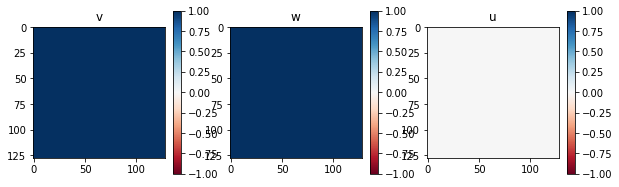

CPU times: user 3min 7s, sys: 35.8 ms, total: 3min 7s
Wall time: 3min 8s


In [6]:
%%time
state = forward(shape, 100000, params.params_test(), D, [s1, s2], dt)
show(state, vmin=-1, vmax=1, cmap="RdBu")